In [2]:
import os
import sys
os.chdir('c:\\projects\\udacity\\CarND-Advanced-Lane-Lines\\')
sys.path.insert(1, os.getcwd())

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import importlib
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def plot_images(img_src, img_dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_src, cmap='gray')
    ax1.set_title('Source Image', fontsize=50)
    ax2.imshow(img_dst, cmap='gray')
    ax2.set_title('Destination Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

def plot_images_grid(images, cmap=None):
    plt.axis('off')
    grid_cols = 4
    grid_rows = math.ceil(len(images)/grid_cols)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(16, 10))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # TODO fig.suptitle('sample image per class and number of training images')
    for ax, image in zip(axes.flat, images):
        fig = ax.imshow(image, cmap=cmap)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
def plot_image(img):
    plt.imshow(img, cmap='gray')

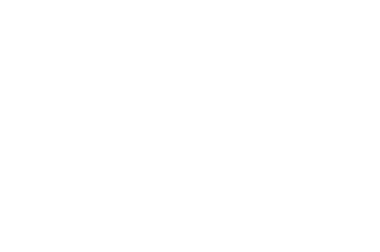

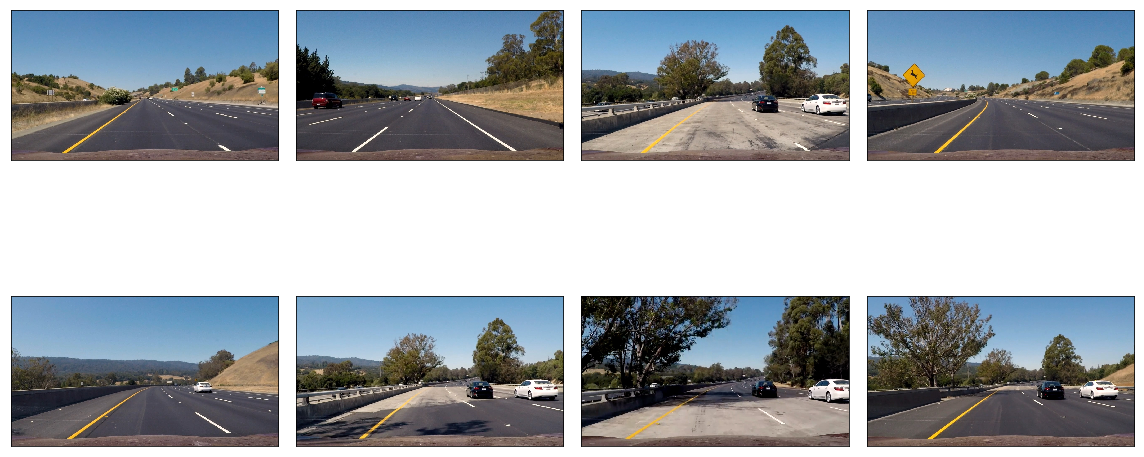

In [5]:
# load test images
import glob
image_files = glob.glob('./test_images/*.jpg')
imgs_camera = []
for img_file in image_files:
    imgs_camera.append(cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB))
plot_images_grid(imgs_camera)

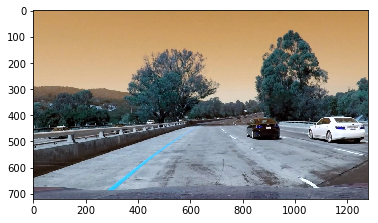

In [6]:
img_camera = cv2.imread('./test_images/test1.jpg')
plot_image(img_camera)

In [7]:
from camera_img_undistorter import CameraImageUndistorter
img_undistorter = CameraImageUndistorter()

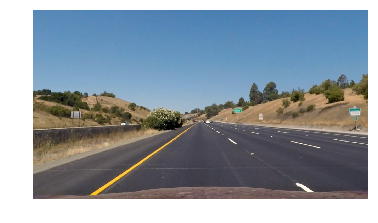

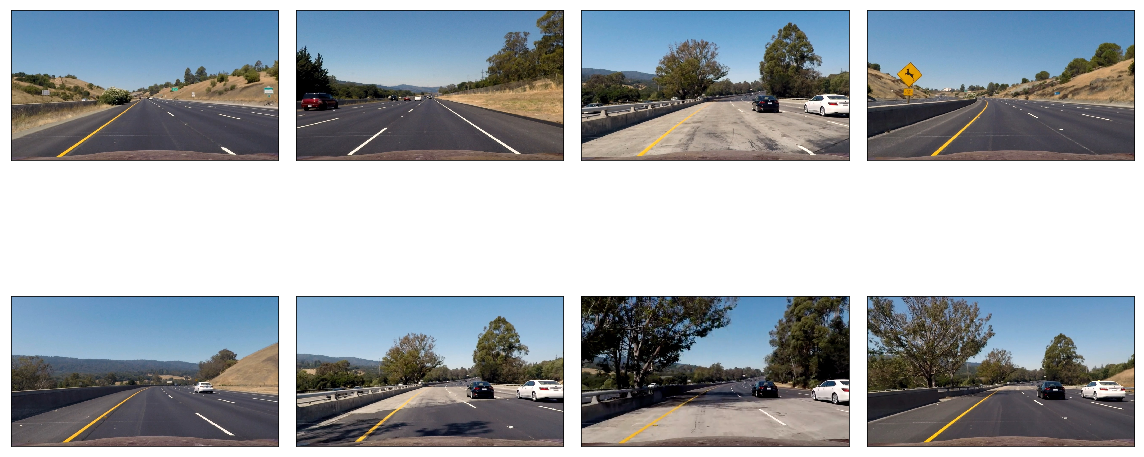

In [8]:
imgs_undistorted = [img_undistorter.undistort(img) for img in imgs_camera] 
plot_image(imgs_undistorted[0])
plot_images_grid(imgs_undistorted)

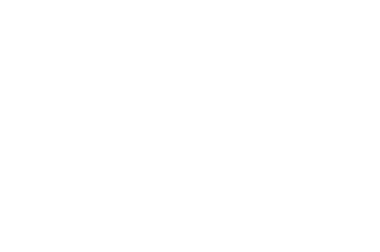

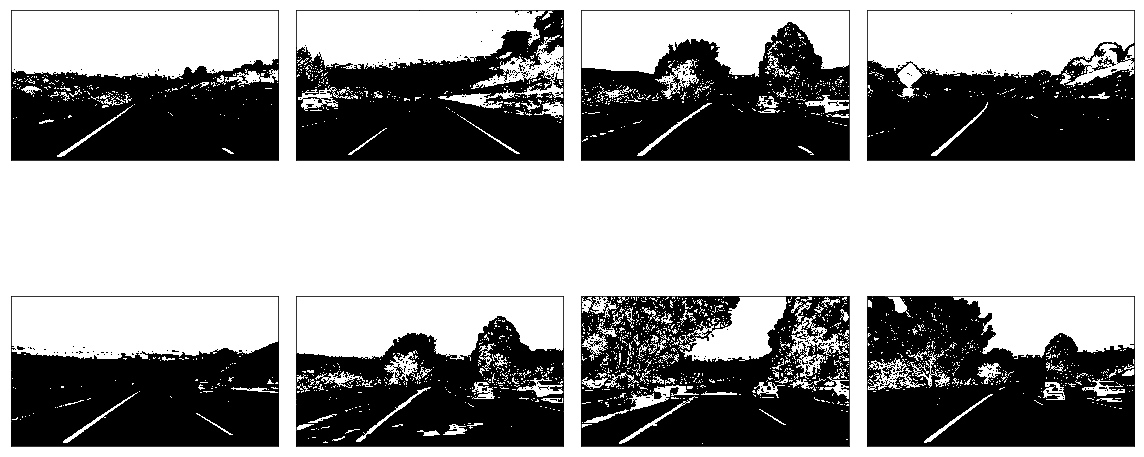

In [9]:
def color_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    thresh = (90, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

imgs_color  = [color_threshold(img) for img in imgs_undistorted] 
plot_images_grid(imgs_color, cmap='gray')

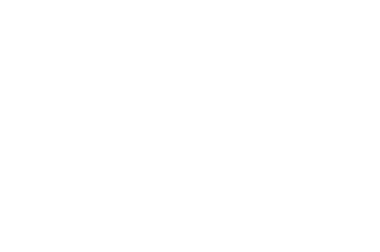

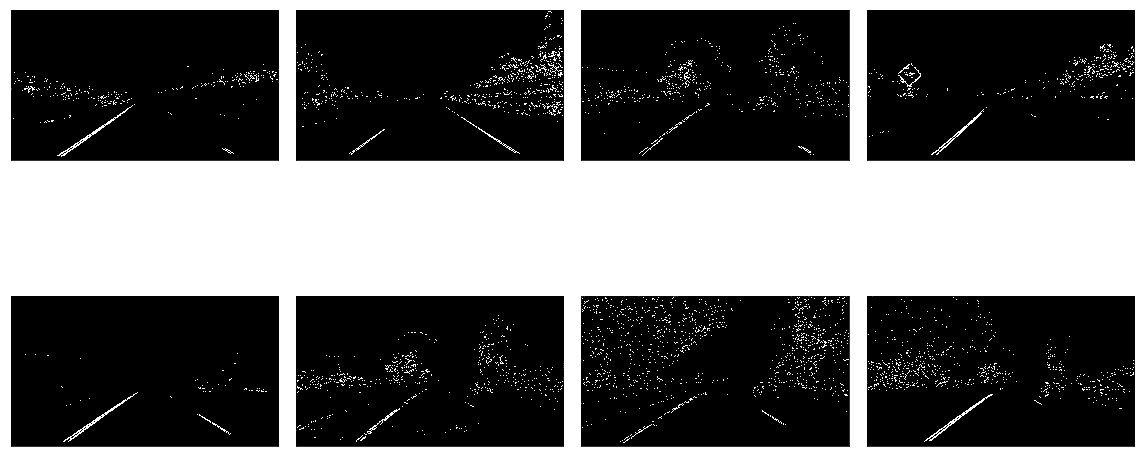

In [10]:
import lane_isolator
importlib.reload(lane_isolator)
from lane_isolator import LaneIsolator
lane_isolator = LaneIsolator(
    ksize=15,
    gradx_thresh=(30, 255),
    grady_thresh=(0, 255),
    mag_thresh=(10, 255),
    dir_thresh = (0.7, 1.3))
imgs_lanes  = [lane_isolator.isolate_lanes(img) for img in imgs_undistorted] 
plot_images_grid(imgs_lanes, cmap='gray')

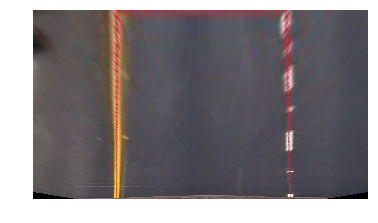

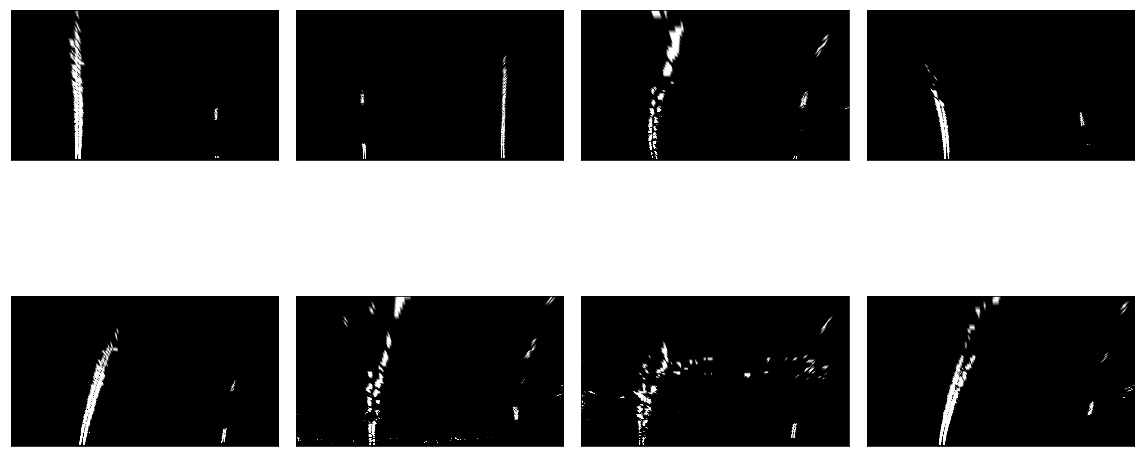

In [28]:
import camera_birdview_transform
importlib.reload(camera_birdview_transform)
from camera_birdview_transform import CameraImagePerspectiveTransform
img_transformer = CameraImagePerspectiveTransform()
imgs_lanes_birdview = [img_transformer.to_birdview(img) for img in imgs_lanes] 
plot_image(img_transformer.to_birdview(cv2.cvtColor(cv2.imread('./examples/straight_lines1_source_points.jpg'), cv2.COLOR_BGR2RGB)))
plot_images_grid(imgs_lanes_birdview, cmap='gray')

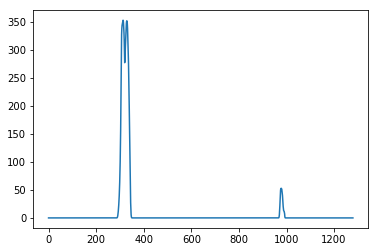

In [12]:
histograms = [np.sum(img[img.shape[0]//2:,:], axis=0) for img in imgs_lanes_birdview]
plt.plot(histograms[0])

In [43]:
class FittedLane:
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    def __init__(self, left_fit, right_fit, left_fit_cr, right_fit_cr, out_img):
        self.left_fit = left_fit
        self.right_fit = right_fit
        self.left_fit_cr = left_fit_cr
        self.right_fit_cr = right_fit_cr
        self.out_img = out_img
        
def lane_fit(img):

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Colorize the left and right lane pixels
    # TODO
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = FittedLane.ym_per_pix
    xm_per_pix = FittedLane.xm_per_pix
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return FittedLane(left_fit, right_fit, left_fit_cr, right_fit_cr, out_img)

# fit lanes
fitted_lanes = [lane_fit(img_birdview) for img_birdview in imgs_lanes_birdview]

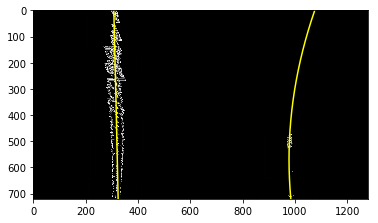

In [17]:
def plot_lanes(fitted_lane):
    left_fit = fitted_lane.left_fit
    right_fit = fitted_lane.right_fit
    out_img = fitted_lane.out_img
    
    # Generate x and y values for plotting
    img_width = out_img.shape[0]
    ploty = np.linspace(0, img_width-1, img_width )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_lanes(fitted_lanes[0])

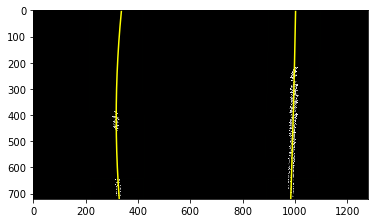

In [16]:
plot_lanes(fitted_lanes[1])

In [47]:
# TODO compute deviation from center
def deviation_from_lane_center(fitted_lane):
    left_fit = fitted_lane.left_fit
    right_fit = fitted_lane.right_fit
    y = fitted_lane.out_img.shape[1] - 1
    left_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    camera_x =(right_x - left_x) / 2 + left_x
    center_x = fitted_lane.out_img.shape[0]/2
    deviation_x = camera_x - center_x
    deviation_meters = deviation_x*FittedLane.xm_per_pix
    return deviation_meters
    
print(deviation_from_lane_center(fitted_lanes[0]))

1.96746518189


In [44]:
# compute lane curve radius
def lane_radius(fitted_lane):
    y_eval = fitted_lane.out_img.shape[1] - 1
    left_fit_cr = fitted_lane.left_fit_cr
    right_fit_cr = fitted_lane.right_fit_cr
    ym_per_pix = FittedLane.ym_per_pix
    xm_per_pix = FittedLane.xm_per_pix
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

print(lane_radius(fitted_lanes[0]))

(47400.710431177438, 544.97822381788956)


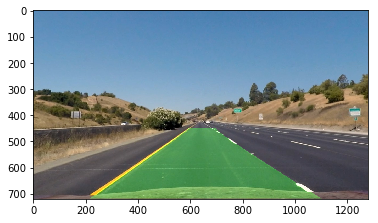

In [29]:
# TODO draw in original image

def plot_in_original(undist, fitted_lane):
    # Create an image to draw the lines on
    warp_zero = np.zeros((undist.shape[0], undist.shape[1])).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate points for plotting
    left_fit = fitted_lane.left_fit
    right_fit = fitted_lane.right_fit
    img_width = color_warp.shape[0]
    ploty = np.linspace(0, img_width-1, img_width )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = img_transformer.birdview_to_camera(color_warp) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    
plot_in_original(imgs_undistorted[0], fitted_lanes[0])

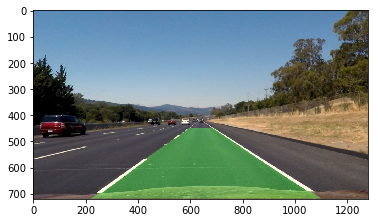

In [31]:
plot_in_original(imgs_undistorted[1], fitted_lanes[1])

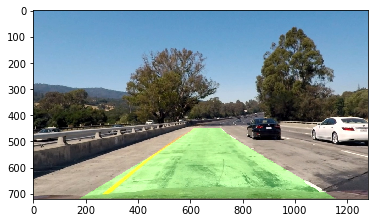

In [32]:
plot_in_original(imgs_undistorted[2], fitted_lanes[2])